# Cloudydap Cost Modeling

Implements a cost model developed for the Cloudydap in AWS trade study. The cost estimates generated by the model are in the form of a pandas DataFrame. A combination of the model parameters represents one _scenario_. Each scenario in the DataFrame must have a unique name but the cost DataFrame can hold more scenarios. The idea is that the cost estimates could be compared between different scenarios.

This DataFrame can also be copied to the clipboard and pasted into a spreadsheet program.

In [1]:
import pandas as pd
from IPython.display import display, clear_output
from ipywidgets import *
from aws_price_list import AWSOffersIndex

pd.set_option('display.max_rows', None)

The function below is the Cloudydap cost model. It has a number of parameters with the default values.

In [2]:
def cloudydap_cost(ec2, s3,
                   ec2_sku='47GP959QAF69YPG5',
                   num_hyrax=1,
                   ec2_storage_sku='HY3BZPP2B6K8MSJF',
                   ec2_storage_backup='7U7TWP44UP36AT3R',
                   ec2_storage_size=5,
                   s3_sku='WP9ANXZGBYYSGJEA',
                   data_size=115,
                   arch3_data_reduction=30,
                   dmrpp_size=.27970830719321672100,
                   num_files=365,
                   num_dsets=777,
                   max_bstreams=8,
                   egress_data_size=16.63597430725,
                   egress_sku='HQEH3ZWJVT46JHRG',
                   s3_req_sku='ZWQ6Q48CRJXX4FXE',
                   num_dap_data_reqs={'max': 63712, 'min': 0},
                   num_dap_meta_reqs={'max': 9286, 'min': 0},
                   time_interval='day'):
    """Compute estimate of Cloudydap AWS costs.

    Arguments:

        ec2: Instance of the class representing AWS EC2 price data.

        s3: Instance of the class representing AWS S3 price data.

        ec2_sku: EC2 instance price as AWS product SKU

        num_hyrax: Number of Hyrax servers (assuming one Hyrax server per EC2
            instance)

        ec2_storage_sku: File system for Hyrax server(s) price AWS product SKU

        ec2_storage_backup: File system's backup price as AWS product SKU

        ec2_storage_size: File system size in gigabytes (GB)

        s3_sku: S3 storage price as AWS product SKU

        data_size: Data collection's size in gigabytes (GB)

        arch3_data_reduction: Saving as percentage in data storage from file
            shredding

        dmrpp_size: Size of DMR++ (index) files as percentage of the data
            collection's size.

        num_files: Number of files in the data collection.

        num_dsets: Number of datasets (variables) per file.

        max_bstreams: Maximum number of byte streams per dataset.

        egress_data_size: Daily amount of egress data in gigabytes (GB).

        egress_sku: Data egress price as AWS product SKU.

        s3_req_sku: S3 requests price as AWS product SKU.

        num_dap_data_reqs: Min/max number of DAP data requests per day.

        num_dap_meta_reqs: Min/max number of DAP metadata requests per day.

        time_unit: Time interval of cost data. Can be: monthly, daily, hourly.
    """
    # Helper function to check price units...
    def _check_units(units, expected):
        if units != expected:
            raise ValueError('Units mismatch: "%s", expected "%s"'
                             % (units, expected))

    # Cost data will be stored in a pandas' DataFrame, using the same column
    # names as those in the Detailed Hourly AWS Cost and Usage Reports.
    cost = pd.DataFrame(columns=['Arch', 'lineItem/ProductCode',
                                 'lineItem/UsageType', 'lineItem/Operation',
                                 'lineItem/BlendedCost'])

    # ## Cost Calculation

    # The costs will be calculated based on the specified time interval. It can
    # be monthly, daily, or hourly.
    days_in_month = 30
    if time_interval == 'month':
        time_unit = 1
    elif time_interval == 'day':
        time_unit = days_in_month
    elif time_interval == 'hour':
        time_unit = days_in_month * 24
    else:
        raise ValueError('%s: Invalid time interval' % time_interval)

    # ### EC2 Cost
    x = ec2.product(ec2_sku).pricing[0]
    _check_units(x.price_unit, 'Hrs')
    x = num_hyrax * x.get_price((days_in_month * 24) / time_unit)
    cost.loc[len(cost)] = pd.Series({'Arch': 'A1',
                                     'lineItem/ProductCode': 'AmazonEC2',
                                     'lineItem/UsageType': 'BoxUsage',
                                     'lineItem/Operation': 'RunInstances',
                                     'lineItem/BlendedCost': x})
    cost.loc[len(cost)] = pd.Series({'Arch': 'A2',
                                     'lineItem/ProductCode': 'AmazonEC2',
                                     'lineItem/UsageType': 'BoxUsage',
                                     'lineItem/Operation': 'RunInstances',
                                     'lineItem/BlendedCost': x})
    cost.loc[len(cost)] = pd.Series({'Arch': 'A3',
                                     'lineItem/ProductCode': 'AmazonEC2',
                                     'lineItem/UsageType': 'BoxUsage',
                                     'lineItem/Operation': 'RunInstances',
                                     'lineItem/BlendedCost': x})

    # ### EC2 Local Storage Cost for A1
    x = ec2.product(ec2_storage_sku).pricing[0]
    _check_units(x.price_unit, 'GB-Mo')
    x = x.get_price(ec2_storage_size) / time_unit
    cost.loc[len(cost)] = pd.Series({'Arch': 'A1',
                                     'lineItem/ProductCode': 'AmazonEC2',
                                     'lineItem/UsageType': 'EBS:VolumeUsage',
                                     'lineItem/Operation': 'CreateVolume',
                                     'lineItem/BlendedCost': x})

    x = ec2.product(ec2_storage_backup).pricing[0]
    _check_units(x.price_unit, 'GB-Mo')
    x = x.get_price(ec2_storage_size) / time_unit
    cost.loc[len(cost)] = pd.Series({'Arch': 'A1',
                                     'lineItem/ProductCode': 'AmazonEC2',
                                     'lineItem/UsageType': 'EBS:SnapshotUsage',
                                     'lineItem/Operation': 'CreateSnapshot',
                                     'lineItem/BlendedCost': x})

    # ### S3 Storage Cost
    s3_storage_pricing = s3.product(s3_sku).pricing[0]
    _check_units(s3_storage_pricing.price_unit, 'GB-Mo')

    # For Architecture \#1:
    x = s3_storage_pricing.get_price(data_size) / time_unit
    cost.loc[len(cost)] = pd.Series({'Arch': 'A1',
                                     'lineItem/ProductCode': 'AmazonS3',
                                     'lineItem/UsageType': 'TimedStorage',
                                     'lineItem/Operation': 'StandardStorage',
                                     'lineItem/BlendedCost': x})

    # For Architecture \#2: data collection plus the DMR++ (index) files.
    x = s3_storage_pricing.get_price(
        data_size * (1 + dmrpp_size/100)) / time_unit
    cost.loc[len(cost)] = pd.Series({'Arch': 'A2',
                                     'lineItem/ProductCode': 'AmazonS3',
                                     'lineItem/UsageType': 'TimedStorage',
                                     'lineItem/Operation': 'StandardStorage',
                                     'lineItem/BlendedCost': x})

    # For Architecture \#3: data collection minus the reduction from duplicate
    # byte streams plus the DMR++ (index) files.
    x = s3_storage_pricing.get_price(
        data_size * (1 + (dmrpp_size - arch3_data_reduction)/100)) / time_unit
    cost.loc[len(cost)] = pd.Series({'Arch': 'A3',
                                     'lineItem/ProductCode': 'AmazonS3',
                                     'lineItem/UsageType': 'TimedStorage',
                                     'lineItem/Operation': 'StandardStorage',
                                     'lineItem/BlendedCost': x})

    # ### Egress Data
    x = ec2.product(egress_sku).pricing[0]
    _check_units(x.price_unit, 'GB')
    x = x.get_price(egress_data_size * (days_in_month / time_unit))
    for arch in ['A1', 'A2', 'A3']:
        cost.loc[len(cost)] = pd.Series(
            {'Arch': arch,
             'lineItem/ProductCode': 'AmazonEC2',
             'lineItem/UsageType': 'DataTransfer-Out-Bytes',
             'lineItem/Operation': 'RunInstances',
             'lineItem/BlendedCost': x})

    # ### DAP Requests
    #
    # This part is about modelling the cost of S3 requests. There are two types
    # of DAP requests: data and metadata. For metadata requests, we will assume
    # only one S3 request to retrieve the DMR++ (index) file. For data DAP
    # requests, one S3 request for Architecture \#1 and either 1 or
    # `max_bstreams` for Architecture \#2 and \#3.
    s3_reqs = s3.product(s3_req_sku).pricing[0]
    _check_units(s3_reqs.price_unit, 'Requests')

    # DAP metadata and data requests translated into S3 requests:
    for arch in ['A1', 'A2', 'A3']:
        for cat in ['min', 'max']:
            # S3 requests cost from DAP metadata requests...
            meta_cost = s3_reqs.get_price(
                num_dap_meta_reqs[cat] * 1 * (days_in_month / time_unit))

            # S3 requests cost from DAP data requests...
            if arch == 'A1':
                data_cost = s3_reqs.get_price(
                    num_dap_data_reqs[cat] * 1 * (days_in_month / time_unit))
                cost.loc[len(cost)] = pd.Series(
                    {'Arch': arch, 'lineItem/ProductCode': 'AmazonS3',
                     'lineItem/UsageType': 'Requests-Tier2',
                     'lineItem/Operation': 'GetObject',
                     'lineItem/BlendedCost': meta_cost + data_cost})
            else:
                for n in [1, max_bstreams]:
                    data_cost = s3_reqs.get_price(
                        num_dap_data_reqs[cat] * n * (days_in_month / time_unit))
                    cost.loc[len(cost)] = pd.Series(
                        {'Arch': arch, 'lineItem/ProductCode': 'AmazonS3',
                         'lineItem/UsageType': 'Requests-Tier2',
                         'lineItem/Operation': 'GetObject',
                         'lineItem/BlendedCost': meta_cost + data_cost})

    return cost

## Preparation

Cost data will be stored in a pandas' DataFrame, using the same column names as those in the Detailed Hourly AWS Cost and Usage Reports.

In [3]:
cost = pd.DataFrame(columns=['Scenario', 'Arch', 'lineItem/ProductCode', 
                             'lineItem/UsageType', 'lineItem/Operation', 
                             'lineItem/BlendedCost'])

## AWS Price Information

### AWS Offer Index File

In [4]:
oi = AWSOffersIndex()

In [5]:
oi.published.strftime('%c %Z')

'Mon Mar 20 17:40:39 2017 UTC+00:00'

In [6]:
oi.accessed.strftime('%c %Z')

'Tue Mar 28 17:10:59 2017 UTC+00:00'

### Amazon EC2 Price Data

In [7]:
ec2 = oi.offer('AmazonEC2')

In [8]:
ec2.published.strftime('%c %Z')

'Fri Mar 24 21:19:55 2017 UTC+00:00'

In [9]:
ec2.accessed.strftime('%c %Z')

'Tue Mar 28 17:11:14 2017 UTC+00:00'

### Amazon S3 Price Data

In [10]:
s3 = oi.offer('AmazonS3')

In [11]:
s3.published.strftime('%c %Z')

'Fri Jan 27 22:16:42 2017 UTC+00:00'

In [12]:
s3.accessed.strftime('%c %Z')

'Tue Mar 28 17:11:14 2017 UTC+00:00'

## Cost Computation Dashboard

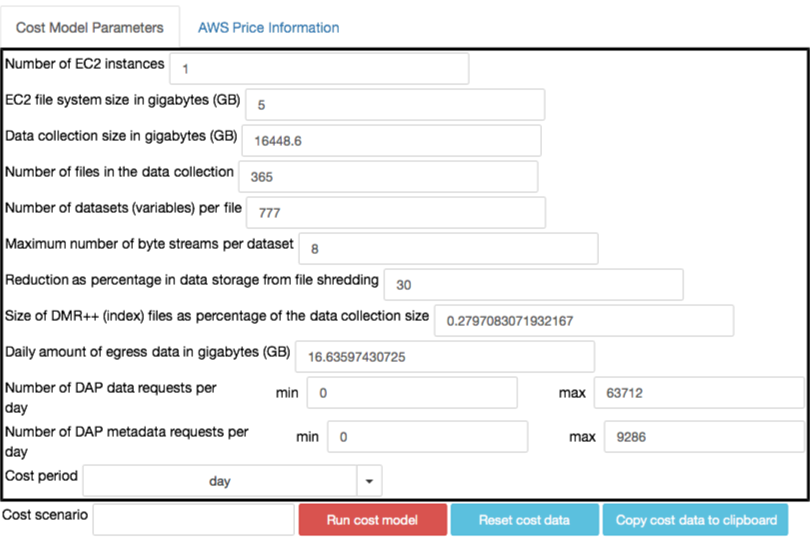

In [13]:
ec2_sku = Text(value='47GP959QAF69YPG5', disabled=True)
ec2_storage_sku = Text(value='HY3BZPP2B6K8MSJF', disabled=True)
ec2_storage_backup = Text(value='7U7TWP44UP36AT3R', disabled=True)
s3_sku = Text(value='WP9ANXZGBYYSGJEA', disabled=True)
egress_sku = Text(value='HQEH3ZWJVT46JHRG', disabled=True)
s3_req_sku = Text(value='ZWQ6Q48CRJXX4FXE', disabled=True)

vb1 = VBox([
    HBox([Label('EC2 instance price as AWS product SKU'), ec2_sku]),
    HBox([Label('EC2 file system price as AWS product SKU'), 
        ec2_storage_sku]),
    HBox([Label('EC2 file system backup price as AWS product SKU'), 
        ec2_storage_backup]),
    HBox([Label('S3 storage price as AWS product SKU'), s3_sku]),
    HBox([Label('Data egress price as AWS product SKU'), egress_sku]),
    HBox([Label('S3 requests price as AWS product SKU'), s3_req_sku])], 
    layout=Layout(border='solid'))

num_hyrax = IntText(value=1, disabled=False)
ec2_storage_size = FloatText(value=5, disabled=False)
data_size = FloatText(value=16448.6, disabled=False)
arch3_data_reduction = FloatText(value=30, disabled=False)
dmrpp_size = FloatText(value=.27970830719321672100, disabled=False)
num_files = IntText(value=365, disabled=False)
num_dsets = IntText(value=777, disabled=False)
max_bstreams = IntText(value=8, disabled=False)
egress_data_size = FloatText(value=16.63597430725, disabled=False)
num_dap_data_reqs_max = IntText(value=63712, description= 'max', disabled=False)
num_dap_data_reqs_min = IntText(value=0, description='min', disabled=False)
num_dap_meta_reqs_max = IntText(value=9286, description='max', disabled=False)
num_dap_meta_reqs_min = IntText(value=0, description='min', disabled=False)
time_interval = Dropdown(options=['month', 'day', 'hour'], value='day')

vb2 = VBox([
    HBox([Label('Number of EC2 instances'), num_hyrax]),
    HBox([Label('EC2 file system size in gigabytes (GB)'), ec2_storage_size]),
    HBox([Label('Data collection size in gigabytes (GB)'), data_size]),
    HBox([Label('Number of files in the data collection'), num_files]),
    HBox([Label('Number of datasets (variables) per file'), num_dsets]),
    HBox([Label('Maximum number of byte streams per dataset'), max_bstreams]),
    HBox([Label('Reduction as percentage in data storage from file shredding'), arch3_data_reduction]),
    HBox([Label('Size of DMR++ (index) files as percentage of the data collection size'), dmrpp_size]),
    HBox([Label('Daily amount of egress data in gigabytes (GB)'), egress_data_size]),
    HBox([Label('Number of DAP data requests per day'), num_dap_data_reqs_min, num_dap_data_reqs_max]),
    HBox([Label('Number of DAP metadata requests per day'), num_dap_meta_reqs_min, num_dap_meta_reqs_max]),
    HBox([Label('Cost period'), time_interval])
], layout=Layout(border='solid'))

scenario = Text(value='', layout=Layout(width='25%'))
run = Button(description='Run cost model', button_style='danger')
reset = Button(description='Reset cost data', button_style='info')
copy = Button(description='Copy cost data to clipboard', button_style='info')
copy.layout.width = '185px'


def reset_costs(b):
    global cost

    clear_output()
    cost.drop(cost.index, inplace=True)
    display(cost)

    
def run_model(b):
    global cost

    clear_output()
    if not scenario.value:
        raise ValueError('Please set the cost scenario.')
    else:
        if (cost.Scenario == scenario.value).any():
            raise ValueError('%s: Scenario name alredy used' % scenario.value)

    num_dap_data_reqs = {'max': num_dap_data_reqs_max.value,
                         'min': num_dap_data_reqs_min.value}
    num_dap_meta_reqs = {'max': num_dap_meta_reqs_max.value,
                         'min': num_dap_meta_reqs_min.value}
    this_cost = cloudydap_cost(
        ec2, 
        s3,
        num_hyrax=num_hyrax.value,
        ec2_storage_size=ec2_storage_size.value,
        data_size=data_size.value,
        arch3_data_reduction=arch3_data_reduction.value,
        dmrpp_size=dmrpp_size.value,
        num_files=num_files.value,
        num_dsets=num_dsets.value,
        max_bstreams=max_bstreams.value,
        egress_data_size=egress_data_size.value,
        num_dap_data_reqs=num_dap_data_reqs,
        num_dap_meta_reqs=num_dap_meta_reqs,
        time_interval=time_interval.value)
    this_cost['Scenario'] = scenario.value
    scenario.value = ''

    cost = cost.append(this_cost, ignore_index=True)[cost.columns.tolist()]
    display(cost)

    
def copy_clip(b):
    global cost

    cost.to_clipboard(index=False)


run.on_click(run_model)
reset.on_click(reset_costs)
copy.on_click(copy_clip)

t = Tab([vb2, vb1])
t.set_title(0, 'Cost Model Parameters')
t.set_title(1, 'AWS Price Information')

VBox([t, HBox([Label('Cost scenario'), scenario, run, reset, copy])])